# Basin Data Preprocessing with Improved Normalization Strategy 1: Log-Transform Before Area Normalization

**Date: 2025-06-18**

**Strategy 1: Log-Transform Before Area Normalization**

This section implements the recommended approach to address numerical instability issues identified in the previous normalization strategy. Instead of directly normalizing discharge by basin area (which can create extreme values), we:

1. **First apply log transformation** to discharge to compress the range and stabilize values
2. **Then normalize by (scaled) basin area** to account for basin size differences  
3. **Apply global z-score normalization** for consistent scaling across all variables

**Key Benefits:**
- **Numerical Stability**: Log transformation prevents extreme values from discharge/area normalization
- **Preserved Relationships**: Maintains the relative relationships between discharge and basin characteristics
- **Better Model Performance**: More stable input features for LSTM training
- **Reduced Variance**: Compressed value ranges reduce the risk of gradient explosion/vanishing

**Normalization Order:**
1. Area normalization: `log_discharge / (basin_area / scale_factor)`  
2. Log-transform discharge: `log(discharge + ε)`
3. Global z-score: `(value - global_mean) / global_std`

This approach addresses the extreme values identified in the distribution analysis and provides a more robust preprocessing pipeline for hydrological modeling.

## Summary Statistics

**GAGEii**

| Variable    | Global Mean   | Global Std    | Valid Values    |
|-------------|--------------|--------------|----------------|
| discharge   | -0.3934      | 1.2770       | 7,089,267      |
| dayl        | 43,191.3542  | 8,322.7121   | 11,752,650     |
| prcp        | -6.8471      | 7.4811       | 11,752,650     |
| srad        | 297.5412     | 134.1672     | 11,752,650     |
| swe         | -6.4978      | 8.5386       | 11,752,650     |
| tmax        | 12.0354      | 11.7481      | 11,752,650     |
| tmin        | 1.5506       | 10.8179      | 11,752,650     |
| vp          | 846.7423     | 560.0107     | 11,752,650     |

Combined training dataset shape: (11,752,650, 9)  
Training period: 1980-01-01 to 2012-12-31

Global statistics calculated from TRAINING SET for 8 variables.  
These statistics will be applied to both training and test sets.

**LBRM**

| Variable    | Global Mean   | Global Std    | Valid Values    |
|-------------|--------------|--------------|----------------|
| discharge   | -0.3888      | 1.1913       | 1,029,784      |
| dayl        | 43,200.1427  | 8,419.1657   | 1,300,860      |
| prcp        | -6.0231      | 7.3083       | 1,300,860      |
| srad        | 296.9762     | 130.8726     | 1,300,860      |
| swe         | -6.0590      | 8.4514       | 1,300,860      |
| tmax        | 12.1587      | 11.7089      | 1,300,860      |
| tmin        | 1.5371       | 10.8191      | 1,300,860      |
| vp          | 843.8763     | 559.6128     | 1,300,860      |

Combined training dataset shape: (1,300,860, 9)  
Training period: 1980-01-01 to 2012-12-30

Global statistics calculated from TRAINING SET for 8 variables.  
These statistics will be applied to both training and test sets.


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- Configuration for Strategy 1: Log-Transform Before Area Normalization ---
ATTRIBUTES_FILE = '../metadata/attributes.csv'
INPUT_CSV_DIR = '../metadata/csv_filtered'
OUTPUT_NC_DIR = '../data/time_series_gl_area_norm'  # New output directory for this strategy

# Ensure output directory exists
os.makedirs(OUTPUT_NC_DIR, exist_ok=True)

# Variables to log transform BEFORE area normalization (key difference)
LOG_TRANSFORM_VARS = ['discharge', 'prcp', 'swe']
EPSILON = 1e-6  # Small constant to avoid log(0)
BASIN_AREA_SCALE_DIVISOR = 100.0  # Factor to divide basin_area by

# Variables to normalize globally (after log+area normalization for discharge)
# Note: 'discharge' here will be log-transformed THEN area-normalized
NORMALIZE_VARS = ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']

print("Configuration for Strategy 1: Log-Transform Before Area Normalization")
print(f"Input CSV Directory: {INPUT_CSV_DIR}")
print(f"Output NetCDF Directory: {OUTPUT_NC_DIR}")
print(f"Basin Area Scale Divisor: {BASIN_AREA_SCALE_DIVISOR}")
print(f"Variables for log transformation: {LOG_TRANSFORM_VARS}")
print(f"Variables for global normalization: {NORMALIZE_VARS}")
print(f"Epsilon for log transform: {EPSILON}")

Configuration for Strategy 1: Log-Transform Before Area Normalization
Input CSV Directory: ../metadata/csv_filtered
Output NetCDF Directory: ../data/time_series_gl_area_norm
Basin Area Scale Divisor: 100.0
Variables for log transformation: ['discharge', 'prcp', 'swe']
Variables for global normalization: ['discharge', 'dayl', 'prcp', 'srad', 'swe', 'tmax', 'tmin', 'vp']
Epsilon for log transform: 1e-06


In [2]:
# --- 1. Load attributes for Strategy 1 ---
try:
    attributes_df = pd.read_csv(ATTRIBUTES_FILE)
    # Use gauge_id as index for easy lookup
    attributes_df.set_index('gauge_id', inplace=True)
    print(f"Successfully loaded attributes from '{ATTRIBUTES_FILE}'")
    print(f"Number of basins in attributes: {len(attributes_df)}")
except FileNotFoundError:
    print(f"Error: Attributes file '{ATTRIBUTES_FILE}' not found. Please check the path.")
except KeyError:
    print(f"Error: 'gauge_id' column not found in '{ATTRIBUTES_FILE}'.")

Successfully loaded attributes from '../metadata/attributes.csv'
Number of basins in attributes: 1088


In [3]:
# --- THEN Area Normalize ---
import warnings

basin_csv_files = glob.glob(os.path.join(INPUT_CSV_DIR, "*.csv"))
if not basin_csv_files:
    print(f"Error: No CSV files found in '{INPUT_CSV_DIR}'. Please check the path.")

all_log_then_area_normalized_discharge_values = []
processed_data_for_global_norm = []  # List to store processed data

# Data for comparison plots
scatter_plot_basin_areas = []
scatter_plot_mean_original_discharges = []
scatter_plot_mean_log_discharges = []
scatter_plot_mean_log_area_norm_discharges = []

print(f"\n--- Strategy 1 Pass 1: Log-Transform BEFORE Area Normalization ---")
print("Processing order:")
print("1. Load raw discharge data")
print("2. Apply area normalization: log_discharge / (basin_area / scale_factor)")
print("3. Apply log transformation: log(discharge + ε)")  
print("4. Collect for global normalization")

warnings.filterwarnings('ignore', category=FutureWarning, message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.")
warnings.filterwarnings('ignore', category=RuntimeWarning, message="Mean of empty slice")

skip_count = 0

for csv_file_path in tqdm(basin_csv_files):
    gauge_id_with_extension = os.path.basename(csv_file_path)
    gauge_id = gauge_id_with_extension.replace('.csv', '')

    try:
        basin_area = attributes_df.loc[gauge_id, 'area']
    except KeyError:
        print(f"  Warning: gauge_id '{gauge_id}' not found in attributes.csv. Skipping this basin.")
        skip_count += 1
        continue

    if pd.isna(basin_area) or basin_area <= 0:
        print(f"  Warning: Area for {gauge_id} is {basin_area}. Skipping this basin due to invalid area.")
        skip_count += 1
        continue

    # Load basin time series data
    try:
        df = pd.read_csv(csv_file_path)
    except Exception as e:
        print(f"  Error loading CSV {csv_file_path}: {e}. Skipping.")
        skip_count += 1
        continue

    if 'date' not in df.columns:
        print(f"  Warning: 'date' column not found in {gauge_id}. Skipping.")
        skip_count += 1
        continue
    
    df['date'] = pd.to_datetime(df['date'])

    if 'discharge' not in df.columns:
        print(f"  Warning: 'discharge' column not found in {gauge_id}. Skipping.")
        skip_count += 1
        continue

    # Store original discharge for comparison (only valid values for statistics)
    original_discharge = df['discharge'].copy()
    mean_original_discharge = original_discharge.mean()  # This handles NaN automatically

    # === CRITICAL: PRESERVE TEMPORAL SEQUENCE - DO NOT DROP NaN VALUES ===

    # === STRATEGY: AREA NORMALIZE FIRST, THEN LOG TRANSFORM ===
    discharge_mask = df['discharge'].notna()
    scaled_basin_area = basin_area / BASIN_AREA_SCALE_DIVISOR

    if scaled_basin_area == 0:
        print(f"  Warning: Scaled basin area is 0 for {gauge_id} (original area: {basin_area}). Skipping.")
        skip_count += 1
        continue

    # Step 1: Area normalization (only non-NaN)
    df.loc[discharge_mask, 'discharge'] = df.loc[discharge_mask, 'discharge'] / scaled_basin_area
    mean_area_norm_discharge = df['discharge'].mean()  # For stats

    # Step 2: Log-transform the area-normalized discharge (only non-NaN)
    discharge_mask = df['discharge'].notna()
    df.loc[discharge_mask, 'discharge'] = np.log(df.loc[discharge_mask, 'discharge'] + EPSILON)
    mean_log_area_norm_discharge = df['discharge'].mean()  # For stats

    # Log transform other variables as well (preserving NaN where appropriate)
    for col in LOG_TRANSFORM_VARS:
        if col != 'discharge' and col in df.columns:  # discharge already transformed
            if col in ['prcp', 'swe']:
                df[col].fillna(0.0, inplace=True)
            col_mask = df[col].notna()
            df.loc[col_mask, col] = np.log(df.loc[col_mask, col] + EPSILON)

    # === CRITICAL: SPLIT INTO TRAIN/TEST TO AVOID DATA LEAKAGE ===
    train_mask = df['date'] <= '2012-12-31'
    test_mask = df['date'] >= '2013-01-01'

    df_train = df[train_mask].copy()
    df_test = df[test_mask].copy()

    if len(df_train) == 0:
        skip_count += 1
        continue

    # Collect data for plots and analysis (using training data only, excluding NaN)
    if pd.notna(mean_original_discharge) and pd.notna(basin_area):
        scatter_plot_basin_areas.append(basin_area)
        scatter_plot_mean_original_discharges.append(mean_original_discharge)
        scatter_plot_mean_log_discharges.append(mean_area_norm_discharge)  # Now this is area-norm only
        scatter_plot_mean_log_area_norm_discharges.append(mean_log_area_norm_discharge)  # Now this is log(area-norm)

    # Collect log(area-normalized) discharge values for distribution analysis (only from training period and only non-NaN values)
    train_discharge_values = df_train['discharge'].dropna().tolist()
    all_log_then_area_normalized_discharge_values.extend(train_discharge_values)

    # Store both train and test data for global statistics calculation
    processed_data_for_global_norm.append({
        'gauge_id': gauge_id, 
        'df_train': df_train.copy(),
        'df_test': df_test.copy() if len(df_test) > 0 else None
    })

print(f"\nCompleted. Processed {len(processed_data_for_global_norm)} basins, skipping {skip_count} basins.")
if not processed_data_for_global_norm:
    print("No basin data was successfully processed in Strategy 1.")


--- Strategy 1 Pass 1: Log-Transform BEFORE Area Normalization ---
Processing order:
1. Load raw discharge data
2. Apply area normalization: log_discharge / (basin_area / scale_factor)
3. Apply log transformation: log(discharge + ε)
4. Collect for global normalization


  0%|          | 0/976 [00:00<?, ?it/s]

100%|██████████| 976/976 [00:32<00:00, 29.95it/s]


Completed. Processed 975 basins, skipping 1 basins.



--- Strategy 1: Visualization of Discharge Transformations ---


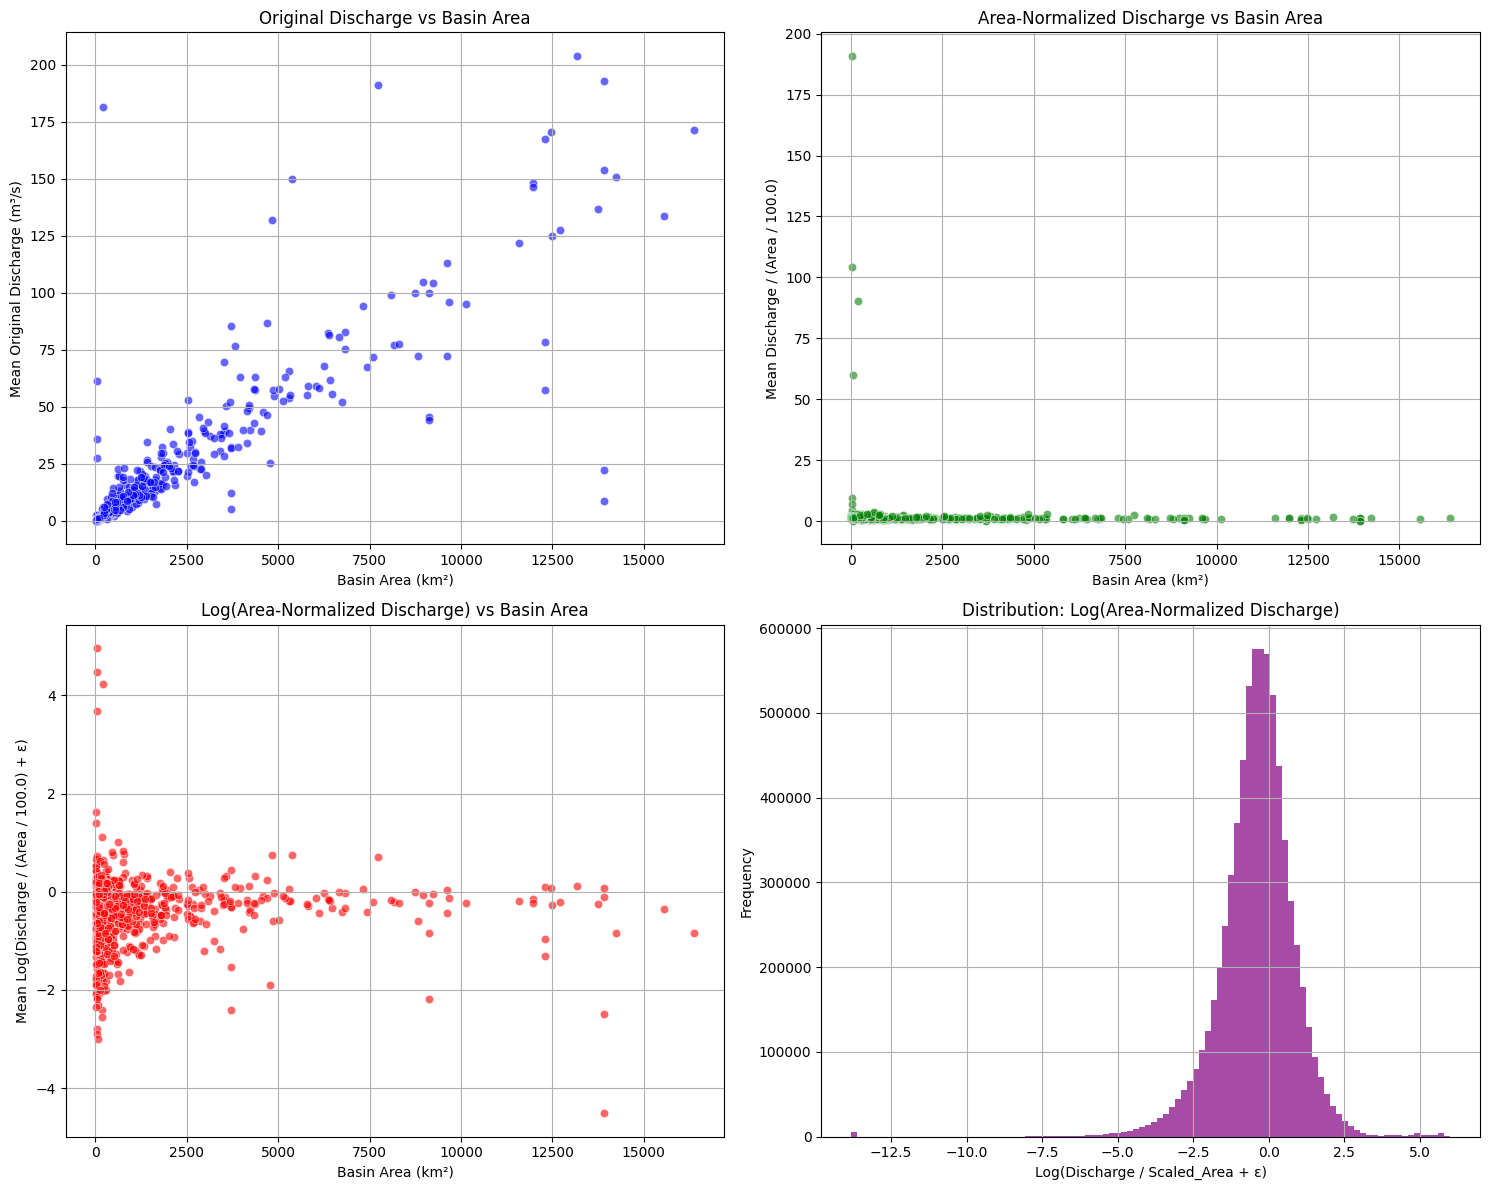


--- Strategy 1 Summary Statistics ---
Original Discharge:
count    858.000000
mean      14.153692
std       27.919092
min        0.038030
25%        1.177993
50%        3.595899
75%       12.208385
max      204.097644
dtype: float64

Area-Normalized Discharge:
count    858.000000
mean       1.780423
std        8.227769
min        0.061454
25%        0.977930
50%        1.178589
75%        1.433390
max      191.003212
dtype: float64

Log(Area-Normalized Discharge):
count    858.000000
mean      -0.392824
std        0.678103
min       -4.514587
25%       -0.665020
50%       -0.308366
75%       -0.051040
max        4.965858
dtype: float64


In [4]:
# --- Visualization: Compare Discharge Transformations ---
print(f"\n--- Strategy 1: Visualization of Discharge Transformations ---")

if (scatter_plot_basin_areas and scatter_plot_mean_original_discharges and 
    scatter_plot_mean_log_discharges and scatter_plot_mean_log_area_norm_discharges):
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Original Discharge vs Basin Area
    axes[0, 0].scatter(scatter_plot_basin_areas, scatter_plot_mean_original_discharges, 
                      alpha=0.6, edgecolors='w', linewidth=0.5, color='blue')
    axes[0, 0].set_title('Original Discharge vs Basin Area')
    axes[0, 0].set_xlabel('Basin Area (km²)')
    axes[0, 0].set_ylabel('Mean Original Discharge (m³/s)')
    axes[0, 0].grid(True)
    
    # Plot 2: Area-Normalized Discharge vs Basin Area  
    axes[0, 1].scatter(scatter_plot_basin_areas, scatter_plot_mean_log_discharges, 
                      alpha=0.6, edgecolors='w', linewidth=0.5, color='green')
    axes[0, 1].set_title('Area-Normalized Discharge vs Basin Area')
    axes[0, 1].set_xlabel('Basin Area (km²)')
    axes[0, 1].set_ylabel(f'Mean Discharge / (Area / {BASIN_AREA_SCALE_DIVISOR})')
    axes[0, 1].grid(True)
    
    # Plot 3: Log(Area-Normalized Discharge) vs Basin Area
    axes[1, 0].scatter(scatter_plot_basin_areas, scatter_plot_mean_log_area_norm_discharges, 
                      alpha=0.6, edgecolors='w', linewidth=0.5, color='red')
    axes[1, 0].set_title('Log(Area-Normalized Discharge) vs Basin Area')
    axes[1, 0].set_xlabel('Basin Area (km²)')
    axes[1, 0].set_ylabel(f'Mean Log(Discharge / (Area / {BASIN_AREA_SCALE_DIVISOR}) + ε)')
    axes[1, 0].grid(True)
    
    # Plot 4: Distribution of Final Normalized Discharge
    axes[1, 1].hist(all_log_then_area_normalized_discharge_values, bins=100, alpha=0.7, color='purple')
    axes[1, 1].set_title('Distribution: Log(Area-Normalized Discharge)')
    axes[1, 1].set_xlabel('Log(Discharge / Scaled_Area + ε)')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n--- Strategy 1 Summary Statistics ---")
    original_stats = pd.Series(scatter_plot_mean_original_discharges)
    area_norm_stats = pd.Series(scatter_plot_mean_log_discharges)
    log_area_stats = pd.Series(scatter_plot_mean_log_area_norm_discharges)
    
    print("Original Discharge:")
    print(original_stats.describe())
    print("\nArea-Normalized Discharge:")  
    print(area_norm_stats.describe())
    print("\nLog(Area-Normalized Discharge):")
    print(log_area_stats.describe())
    
else:
    print("No data available for Strategy 1 visualizations.")


--- Strategy 1: Visualization of Discharge Transformations ---


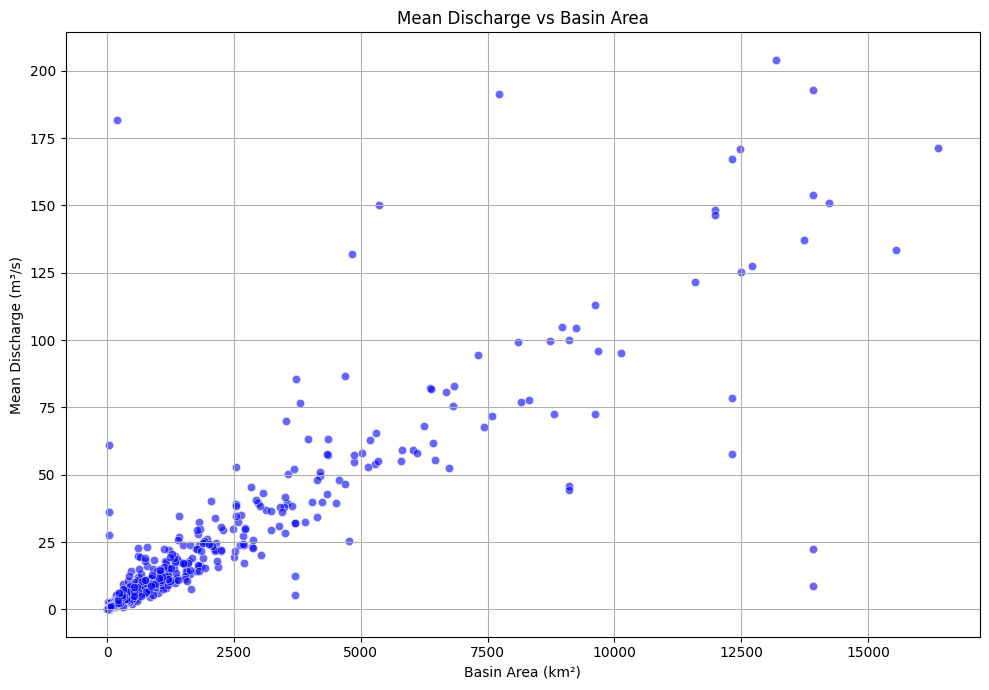

In [11]:
# --- Visualization: Compare Discharge Transformations ---
print(f"\n--- Strategy 1: Visualization of Discharge Transformations ---")

if (scatter_plot_basin_areas and scatter_plot_mean_original_discharges and 
    scatter_plot_mean_log_discharges and scatter_plot_mean_log_area_norm_discharges):
    
    plt.figure(figsize=(10, 7))
    
    # Plot 1: Original Discharge vs Basin Area
    plt.scatter(scatter_plot_basin_areas, scatter_plot_mean_original_discharges, 
                      alpha=0.6, edgecolors='w', linewidth=0.5, color='blue')
    plt.title('Mean Discharge vs Basin Area')
    plt.xlabel('Basin Area (km²)')
    plt.ylabel('Mean Discharge (m³/s)')
    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()
    

In [24]:
# --- Strategy 1: Calculate Global Statistics for Z-Score Normalization (TRAIN SET ONLY) ---
print(f"\n--- Strategy 1: Calculating global statistics from TRAINING data only (1980-2012) ---")
print("🚨 CRITICAL: Using only training set to avoid data leakage!")

if not processed_data_for_global_norm:
    print("No data available for global statistics calculation in Strategy 1. Exiting.")
else:
    # Combine ONLY TRAINING DataFrames to calculate global statistics
    train_dfs = []
    for basin_data in processed_data_for_global_norm:
        if basin_data['df_train'] is not None and len(basin_data['df_train']) > 0:
            train_dfs.append(basin_data['df_train'])
    
    if not train_dfs:
        print("No training data available for global statistics calculation.")
    else:
        combined_train_df = pd.concat(train_dfs, ignore_index=True)
        print(f"Combined training dataset shape: {combined_train_df.shape}")
        print(f"Training period: {combined_train_df['date'].min()} to {combined_train_df['date'].max()}")

        global_means = {}
        global_stds = {}

        for var in NORMALIZE_VARS:
            if var in combined_train_df.columns:
                # Calculate statistics only from non-NaN values
                # pandas mean() and std() automatically handle NaN values
                global_means[var] = combined_train_df[var].mean()  # Excludes NaN
                global_stds[var] = combined_train_df[var].std()    # Excludes NaN
                
                # Check for valid statistics
                if pd.isna(global_means[var]) or pd.isna(global_stds[var]):
                    print(f"  Warning: Could not calculate valid statistics for '{var}' (all values may be NaN). Skipping normalization for this variable.")
                    continue
                    
                # Handle cases where std might be 0 (e.g., if a variable is constant)
                if global_stds[var] == 0:
                    print(f"  Warning: Global standard deviation for '{var}' is 0. Using 1.0 to avoid division by zero.")
                    global_stds[var] = 1.0
                
                # Count valid (non-NaN) values used for statistics
                valid_count = combined_train_df[var].count()
                print(f"  Global mean for {var}: {global_means[var]:.4f}, Global std: {global_stds[var]:.4f} (from {valid_count} valid values)")
            else:
                print(f"  Warning: Variable '{var}' for normalization not found in combined training data. Will not be normalized.")
        
        print(f"\nGlobal statistics calculated from TRAINING SET for {len(global_means)} variables.")
        print("These statistics will be applied to both training and test sets.")


--- Strategy 1: Calculating global statistics from TRAINING data only (1980-2012) ---
🚨 CRITICAL: Using only training set to avoid data leakage!
Combined training dataset shape: (1300860, 9)
Training period: 1980-01-01 00:00:00 to 2012-12-30 12:00:00
  Global mean for discharge: -0.3888, Global std: 1.1913 (from 1029784 valid values)
  Global mean for dayl: 43200.1427, Global std: 8419.1657 (from 1300860 valid values)
  Global mean for prcp: -6.0231, Global std: 7.3083 (from 1300860 valid values)
  Global mean for srad: 296.9762, Global std: 130.8726 (from 1300860 valid values)
  Global mean for swe: -6.0590, Global std: 8.4514 (from 1300860 valid values)
  Global mean for tmax: 12.1587, Global std: 11.7089 (from 1300860 valid values)
  Global mean for tmin: 1.5371, Global std: 10.8191 (from 1300860 valid values)
  Global mean for vp: 843.8763, Global std: 559.6128 (from 1300860 valid values)

Global statistics calculated from TRAINING SET for 8 variables.
These statistics will be app

In [26]:
# --- Final: Apply global z-score normalization to full dataset and save as NetCDF ---
from tqdm import tqdm
import pandas as pd
import xarray as xr
import os

successful_saves = 0
failed_saves = 0

for basin_data in tqdm(processed_data_for_global_norm, desc="Saving full dataset for all basins"):
    gauge_id = basin_data['gauge_id']
    df_train = basin_data['df_train']
    df_test = basin_data.get('df_test')
    # Combine train and test to reconstruct full log+area normalized series
    df_full = pd.concat([df_train, df_test] if df_test is not None else [df_train])
    
    # Sort by date
    df_full.sort_values('date', inplace=True)
    
    # Capture the original dates that exist in the dataset
    original_dates = set(df_full['date'])
    
    # Infer the frequency from the 'date' column and define a full date range.
    # If no frequency can be inferred, use daily frequency ('D').
    inferred_freq = pd.infer_freq(df_full['date'])
    if inferred_freq is None:
        inferred_freq = 'D'
    full_dates = pd.date_range(start=df_full['date'].min(), end=df_full['date'].max(), freq=inferred_freq)
    
    # Determine missing dates (i.e., dates in the full range that are not in the original data)
    missing_dates = sorted(set(full_dates) - original_dates)
    # if missing_dates:
    #     # print(f"Basin {gauge_id}: Missing dates for interpolation:")
    #     for dt in missing_dates:
    #         # print(f"  {dt}")
    # else:
    #     print(f"Basin {gauge_id}: No missing dates.")
    
    # Reindex and interpolate missing dates using time interpolation
    df_full = df_full.set_index('date').reindex(full_dates)
    df_full.index.name = 'date'
    df_full.interpolate(method='time', inplace=True)
    df_full.reset_index(inplace=True)
    df_full.rename(columns={'index': 'date'}, inplace=True)
    
    # Apply global z-score normalization using training-derived statistics
    for var in NORMALIZE_VARS:
        if var in df_full.columns and var in global_means and var in global_stds:
            valid_mask = df_full[var].notna()
            df_full.loc[valid_mask, var] = (df_full.loc[valid_mask, var] - global_means[var]) / global_stds[var]
    
    # Save the full DataFrame as NetCDF, preserving all rows and NaNs
    try:
        ds = xr.Dataset.from_dataframe(df_full.set_index('date'))
        ds.attrs['gauge_id'] = gauge_id
        ds.attrs['preprocessing_strategy'] = 'Strategy1_LogThenAreaNorm'
        output_nc = os.path.join(OUTPUT_NC_DIR, f"{gauge_id}.nc")
        ds.to_netcdf(output_nc)
        successful_saves += 1
    except Exception as e:
        print(f"Failed to save NetCDF for {gauge_id}: {e}")
        failed_saves += 1

print(f"\nNetCDF save complete. Successful: {successful_saves}, Failed: {failed_saves}")

Saving full dataset for all basins: 100%|██████████| 108/108 [00:04<00:00, 25.67it/s]


NetCDF save complete. Successful: 108, Failed: 0


# LBRM Preprocessing (without Area Normalization)


In [6]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

INPUT_CSV_DIR = '../metadata/Maumee_csv'
OUTPUT_NC_DIR = '../data/time_series_maumee'  

# Ensure output directory exists
os.makedirs(OUTPUT_NC_DIR, exist_ok=True)

# Variables to log transform BEFORE area normalization (key difference)
LOG_TRANSFORM_VARS = ['prcp']
EPSILON = 1e-6  # Small constant to avoid log(0)

# Variables to normalize globally 
NORMALIZE_VARS = ['pcp', 'max_temperature', 'min_temperature', 'rh', 'wnd', 'slr', 'sedyld']

print("Configuration for Strategy 1: Log-Transform Before Area Normalization")
print(f"Input CSV Directory: {INPUT_CSV_DIR}")
print(f"Output NetCDF Directory: {OUTPUT_NC_DIR}")
print(f"Variables for log transformation: {LOG_TRANSFORM_VARS}")
print(f"Variables for global normalization: {NORMALIZE_VARS}")
print(f"Epsilon for log transform: {EPSILON}")

Configuration for Strategy 1: Log-Transform Before Area Normalization
Input CSV Directory: ../metadata/Maumee_csv
Output NetCDF Directory: ../data/time_series_maumee
Variables for log transformation: ['prcp']
Variables for global normalization: ['pcp', 'max_temperature', 'min_temperature', 'rh', 'wnd', 'slr', 'sedyld']
Epsilon for log transform: 1e-06


In [13]:
df_test = pd.read_csv('../metadata/Maumee_csv/1_climate_sediment.csv')
df_test

,date,pcp,max_temperature,min_temperature,rh,wnd,slr,sedyld
0,1992-01-01,0.000,-1.350000,-5.550000,0.7970,2.4,7.86240,5.980000e-12
1,1992-01-02,0.000,0.950000,-7.150000,0.8115,1.9,8.40672,5.980000e-12
2,1992-01-03,0.000,2.850000,-3.250000,0.8225,3.2,3.69792,6.640000e-06
3,1992-01-04,3.048,3.150000,0.050000,0.8665,2.1,2.17728,4.460000e-03
4,1992-01-05,2.032,6.450000,-1.750000,0.7975,2.9,7.94016,1.950000e-03
...,...,...,...,...,...,...,...,...
10953,2021-12-27,0.000,11.111111,-5.000000,0.7995,3.3,7.61184,3.530000e-03
10954,2021-12-28,12.192,4.444444,-3.333333,0.8000,5.0,6.84288,6.080000e-02
10955,2021-12-29,0.762,5.555556,-1.666667,0.8015,3.7,5.54688,1.060000e-03
10956,2021-12-30,11.430,1.111111,-1.666667,0.8990,2.3,7.37856,1.490000e-04


In [14]:
# --- Log Transform ONLY (Skip Area Normalization) with Date Imputation ---
import warnings

from datetime import datetime

basin_csv_files = glob.glob(os.path.join(INPUT_CSV_DIR, "*.csv"))
if not basin_csv_files:
    print(f"Error: No CSV files found in '{INPUT_CSV_DIR}'. Please check the path.")

all_log_transformed_discharge_values = []
processed_data_for_global_norm = []  # List to store processed data

# Data for comparison plots
scatter_plot_mean_original_discharges = []
scatter_plot_mean_log_discharges = []

print("Processing order:")
print("1. Load raw discharge data")
print("2. Impute missing dates by averaging neighbors")
print("3. Apply log transformation: log(discharge + ε)")
print("4. Collect for global normalization")

warnings.filterwarnings('ignore', category=FutureWarning, message="A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.")
warnings.filterwarnings('ignore', category=RuntimeWarning, message="Mean of empty slice")

skip_count = 0

# Define the full date range
full_date_range = pd.date_range(start="1980-01-01", end="2023-12-31", freq="D")

for csv_file_path in tqdm(basin_csv_files):
    gauge_id_with_extension = os.path.basename(csv_file_path)
    gauge_id = gauge_id_with_extension.replace('.csv', '')

    # Load basin time series data
    try:
        df = pd.read_csv(csv_file_path)
    except Exception as e:
        print(f"  Error loading CSV {csv_file_path}: {e}. Skipping.")
        continue
    
    # Replace all negative values (including -999.99) with NaN for all numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].where(df[numeric_cols] >= 0, np.nan)

    # Handle both 'date' and 'time' columns
    if 'date' not in df.columns and 'time' in df.columns:
        df.rename(columns={'time': 'date'}, inplace=True)

    if 'date' not in df.columns:
        print(f)
        print(f"  Warning: Neither 'date' nor 'time' column found in {gauge_id}. Skipping.")
        continue

    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')

    # Reindex to full date range, preserving all columns
    df = df.reindex(full_date_range)

    # Impute missing values by averaging previous and next valid value (linear interpolation)
    # Only interpolate for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cols_to_interpolate = [col for col in numeric_cols if col != 'sedyld']
    df[cols_to_interpolate] = df[cols_to_interpolate].interpolate(method='linear', limit_direction='both')

    # Reset index to restore 'date' column
    df = df.reset_index().rename(columns={'index': 'date'})

    if 'sedyld' not in df.columns:
        print(f"  Warning: 'sedyld' column not found in {gauge_id}. Skipping.")
        skip_count += 1
        continue

    # Store original discharge for comparison (only valid values for statistics)
    original_discharge = df['sedyld'].copy()
    mean_original_discharge = original_discharge.mean()  # This handles NaN automatically

    # === CRITICAL: PRESERVE TEMPORAL SEQUENCE - DO NOT DROP NaN VALUES ===

    # === STRATEGY: LOG TRANSFORM ONLY (while preserving NaN) ===
    discharge_mask = df['sedyld'].notna()
    df.loc[discharge_mask, 'sedyld'] = np.log(df.loc[discharge_mask, 'sedyld'] + EPSILON)
    mean_log_discharge = df['sedyld'].mean()  # This handles NaN automatically

    # Log transform other variables as well (preserving NaN where appropriate)
    for col in LOG_TRANSFORM_VARS:
        if col != 'sedyld' and col in df.columns:  # discharge already transformed
            if col in ['prcp', 'swe']:
                # For precipitation and snow, fill NaN with 0 before log transform (makes sense physically)
                df[col].fillna(0.0, inplace=True)
            col_mask = df[col].notna()
            df.loc[col_mask, col] = np.log(df.loc[col_mask, col] + EPSILON)

    # === CRITICAL: SPLIT INTO TRAIN/TEST TO AVOID DATA LEAKAGE ===
    train_mask = df['date'] <= '2012-12-31'
    test_mask = df['date'] >= '2013-01-01'

    df_train = df[train_mask].copy()
    df_test = df[test_mask].copy()

    if len(df_train) == 0:
        skip_count += 1
        continue

    # Collect log-transformed discharge values for distribution analysis (only from training period and only non-NaN values)
    train_discharge_values = df_train['sedyld'].dropna().tolist()
    all_log_transformed_discharge_values.extend(train_discharge_values)

    # Store both train and test data for global statistics calculation
    processed_data_for_global_norm.append({
        'gauge_id': gauge_id,
        'df_train': df_train.copy(),  # Contains NaN values where appropriate
        'df_test': df_test.copy() if len(df_test) > 0 else None  # Contains NaN values where appropriate
    })

print(f"\nCompleted. Processed {len(processed_data_for_global_norm)} basins, skipping {skip_count} basins.")
if not processed_data_for_global_norm:
    print("No basin data was successfully processed in Strategy 1.")

Processing order:
1. Load raw discharge data
2. Impute missing dates by averaging neighbors
3. Apply log transformation: log(discharge + ε)
4. Collect for global normalization


100%|██████████| 290/290 [00:05<00:00, 48.72it/s]


Completed. Processed 290 basins, skipping 0 basins.


In [18]:
# --- Calculate global statistics from TRAIN SET ONLY and apply normalization, then save as NetCDF ---
import xarray as xr
import re

print("\n--- Calculating global statistics from TRAIN SET ONLY (1980-2012) ---")
train_dfs = []
for basin_data in processed_data_for_global_norm:
    df_train = basin_data['df_train']
    if df_train is not None and len(df_train) > 0:
        train_dfs.append(df_train)

if not train_dfs:
    print("No training data available for global statistics calculation.")
else:
    combined_train_df = pd.concat(train_dfs, ignore_index=True)
    print(f"Combined training dataset shape: {combined_train_df.shape}")
    print(f"Training period: {combined_train_df['date'].min()} to {combined_train_df['date'].max()}")

    global_means = {}
    global_stds = {}

    for var in NORMALIZE_VARS:
        if var in combined_train_df.columns:
            global_means[var] = combined_train_df[var].mean()
            global_stds[var] = combined_train_df[var].std()
            if pd.isna(global_means[var]) or pd.isna(global_stds[var]):
                print(f"  Warning: Could not calculate valid statistics for '{var}'. Skipping normalization for this variable.")
                continue
            if global_stds[var] == 0:
                print(f"  Warning: Global std for '{var}' is 0. Using 1.0 to avoid division by zero.")
                global_stds[var] = 1.0
            valid_count = combined_train_df[var].count()
            print(f"  Global mean for {var}: {global_means[var]:.4f}, Global std: {global_stds[var]:.4f} (from {valid_count} valid values)")
        else:
            print(f"  Warning: Variable '{var}' not found in training data. Will not be normalized.")

    print("\nApplying train-period global statistics to all data and saving as NetCDF...")

    successful_saves = 0
    failed_saves = 0

    for basin_data in tqdm(processed_data_for_global_norm, desc="Saving NetCDFs"):
        gauge_id = basin_data['gauge_id']
        df_train = basin_data['df_train']
        df_test = basin_data['df_test']
        df_full = pd.concat([df_train, df_test] if df_test is not None else [df_train])
        df_full.sort_values('date', inplace=True)

        # Apply global z-score normalization using train-period statistics
        for var in NORMALIZE_VARS:
            if var in df_full.columns and var in global_means and var in global_stds:
                valid_mask = df_full[var].notna()
                df_full.loc[valid_mask, var] = (df_full.loc[valid_mask, var] - global_means[var]) / global_stds[var]

        # Save as NetCDF with only the number as filename
        try:
            ds = xr.Dataset.from_dataframe(df_full.set_index('date'))
            ds.attrs['gauge_id'] = gauge_id
            ds.attrs['preprocessing_strategy'] = 'LogTransform_TrainPeriodNorm'
            number_only = re.match(r"^\d+", gauge_id)
            if number_only:
                output_name = number_only.group(0) + ".nc"
            else:
                output_name = gauge_id + ".nc"
            output_nc = os.path.join(OUTPUT_NC_DIR, output_name)
            ds.to_netcdf(output_nc)
            successful_saves += 1
        except Exception as e:
            print(f"Failed to save NetCDF for {gauge_id}: {e}")
            failed_saves += 1

    print(f"\nNetCDF save complete. Successful: {successful_saves}, Failed: {failed_saves}")


--- Calculating global statistics from TRAIN SET ONLY (1980-2012) ---
Combined training dataset shape: (3495660, 8)
Training period: 1980-01-01 00:00:00 to 2012-12-31 00:00:00
  Global mean for pcp: 1.6662, Global std: 5.6811 (from 3495660 valid values)
  Global mean for max_temperature: 10.9764, Global std: 10.8557 (from 3495660 valid values)
  Global mean for min_temperature: 5.4168, Global std: 6.0596 (from 3495660 valid values)
  Global mean for rh: 0.7184, Global std: 0.0875 (from 3495660 valid values)
  Global mean for wnd: 3.3226, Global std: 1.5745 (from 3495660 valid values)
  Global mean for slr: 12.1917, Global std: 6.7100 (from 3495660 valid values)
  Global mean for sedyld: -12.9832, Global std: 2.3813 (from 2224590 valid values)

Applying train-period global statistics to all data and saving as NetCDF...


Saving NetCDFs: 100%|██████████| 290/290 [00:03<00:00, 75.18it/s]



NetCDF save complete. Successful: 290, Failed: 0


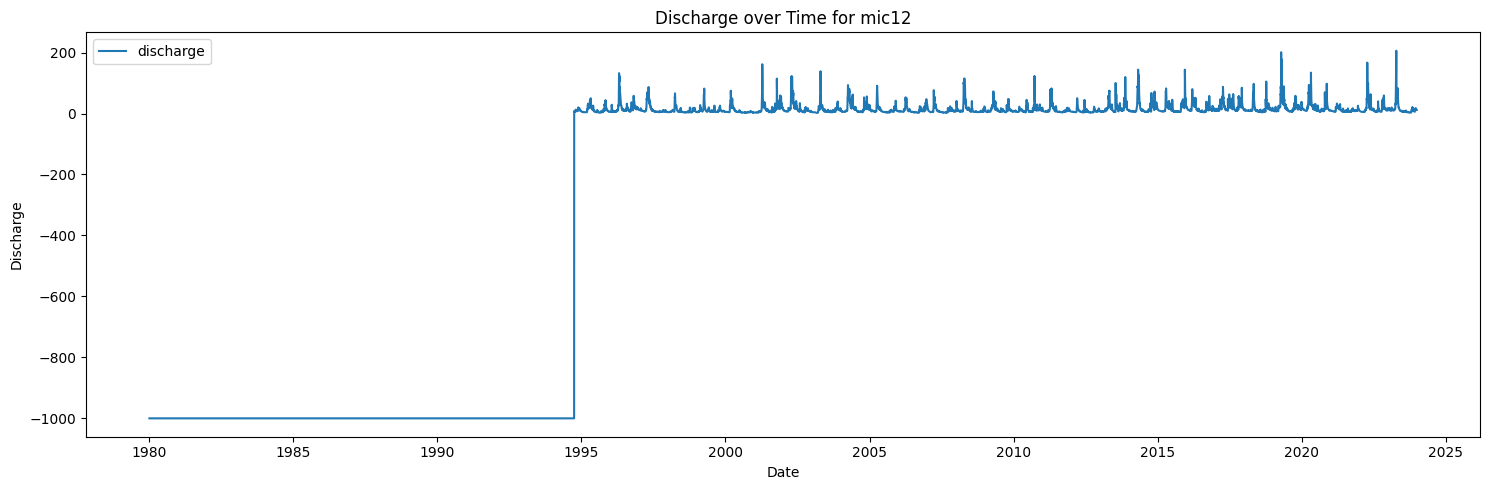

In [25]:
df_mic12 = pd.read_csv("../metadata/LBRM_daymet/mic01.csv", parse_dates=['date'])
plt.figure(figsize=(15, 5))
plt.plot(df_mic12['date'], df_mic12['discharge'], label='discharge')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Discharge over Time for mic12')
plt.legend()
plt.tight_layout()
plt.show()

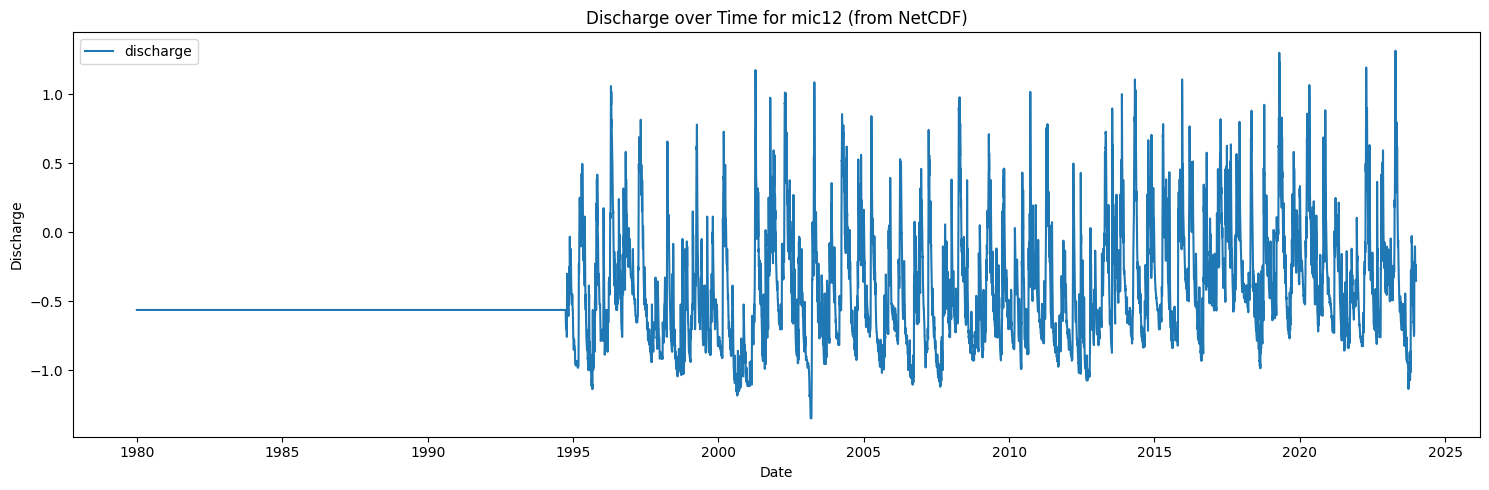

In [26]:
import xarray as xr
import matplotlib.pyplot as plt

# Read NetCDF file
ds_mic12 = xr.open_dataset("../data/time_series_lbrm/mic01.nc")
df_mic12 = ds_mic12.to_dataframe().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(df_mic12['date'], df_mic12['discharge'], label='discharge')
plt.xlabel('Date')
plt.ylabel('Discharge')
plt.title('Discharge over Time for mic12 (from NetCDF)')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
df_mic12

,date,dayl,prcp,srad,swe,tmax,tmin,vp,discharge
0,1980-01-01,-1.478834,-0.913874,-1.614926,1.322087,-1.203185,-0.971876,-0.573604,-0.563427
1,1980-01-02,-1.472581,-0.913874,-1.343878,1.321911,-1.154368,-0.971876,-0.825935,-0.563427
2,1980-01-03,-1.465818,-0.913874,-0.960612,1.321911,-1.105551,-0.971876,-1.113728,-0.563427
3,1980-01-04,-1.458552,-0.913874,-0.692725,1.321911,-1.056735,-0.971876,-1.201639,-0.563427
4,1980-01-05,-1.450789,-0.913874,-0.795005,1.321911,-1.007918,-0.971876,-1.137887,-0.563427
...,...,...,...,...,...,...,...,...,...
16066,2023-12-27,-1.502317,1.153669,-1.896105,-0.805657,-0.916230,-0.728523,-0.259860,-0.234672
16067,2023-12-28,-1.498679,0.893335,-1.902674,-0.805657,-0.952003,-0.682884,-0.236437,-0.246525
16068,2023-12-29,-1.494511,-0.913874,-1.369565,-0.805657,-0.862711,-0.682884,-0.437104,-0.278491
16069,2023-12-30,-1.489816,0.667395,-1.740454,-0.805657,-1.336710,-0.682884,-0.588351,-0.315034
